In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import transforms as T
import torchvision
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import torchvision.models as models
from PIL import Image

In [23]:
np.random.seed(13)
# поскольку pytorch опирается на numpy, то верхней строки достаточно
torch.manual_seed(13)

In [5]:
IMG_DIM = 32
BATCH_SIZE = 128
N_EPOCHS = 3

# такие параметры нормализации требуются для transfer learning,
# но мне кажется, что и для обычных моделей подойдет
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

img_transforms_train = T.Compose([
    T.Resize((IMG_DIM, IMG_DIM)),
    T.RandomHorizontalFlip(),  # аугментация
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)  
])

img_transforms_test = T.Compose([
    T.Resize((IMG_DIM, IMG_DIM)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
])

train_dataset = ImageFolder('./images/train/', img_transforms_train)
test_dataset = ImageFolder('./images/test/', img_transforms_test) 

# лучше размешать тренировочную выборку (shuffle=True), 
# чтобы не было корреляций между примерами
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=0)

In [24]:
images, labels = next(iter(train_loader))
print(f"Shape of image is ({images.shape[0]}, {images.shape[1]}, {images.shape[2]}, {images.shape[3]})")

Shape of image is (128, 3, 32, 32)


In [6]:
losses =[]

# напишу ф-ию для тренировки заранее, так как она не зависит от реализации модели
def train(model, optimizer, loss_fn, train_loader, n_epochs=10, device='cpu'):
    # для каждой эпохи
    for epoch in range(n_epochs):
        run_loss = 0
        # для каждого батча
        for idx, data in enumerate(train_loader, 0):
            inputs, labels = data
            # очищаем вычислительный граф
            optimizer.zero_grad()
            # результат модели
            outputs = model(inputs)
            # считаем потерю
            loss = loss_fn(outputs, labels)
            # обратное распространение ошибки
            loss.backward()
            optimizer.step()
            
            run_loss += loss.item()
            # трекаем потерю
            losses.append(loss.item())
            # вывод
            if idx % 100 == 0:
                print(f"ep #{epoch}, mini-batch #{idx}, loss={run_loss/100}")
                run_loss = 0

In [7]:
# инициализация весов
def weight_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_uniform(model.weight)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # свертка
        self.conv1 = nn.Conv2d(3, 6, 5)
        # batch normalization 
        self.bn1 = nn.BatchNorm2d(6)
        # pooling (субдискретизация)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        
        # dropout with probability = 0.5
        self.dropout1 = nn.Dropout(p=0.5)
        
        # dropout with probability = 0.4 - в данном случае не используется
        self.dropout2 = nn.Dropout(p=0.4)
        # линейные (аффинные) отображения
        self.fc1 = nn.Linear(in_features=400, out_features=120)  
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=42)
 
        self.fc4 = nn.Linear(in_features=42, out_features=2)

    def forward(self, x):
#         nn.init.kaiming_uniform_(self.conv1.weight)
        
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))       
        
        x = x.view(-1, 400)  # reshape
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(F.relu((self.fc2(x))))
        x = F.relu((self.fc3(x)))
        x = self.fc4(x)
        
        return x

In [9]:
net = CNN()
net.apply(weight_init)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  after removing the cwd from sys.path.


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=42, bias=True)
  (fc4): Linear(in_features=42, out_features=2, bias=True)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), 1e-2)

In [11]:
%%time
train(net, optimizer, criterion, train_loader, n_epochs=N_EPOCHS)

ep #0, mini-batch #0, loss=0.006947831511497498
ep #0, mini-batch #100, loss=0.14631417410448194
ep #0, mini-batch #200, loss=0.06768902323208749
ep #1, mini-batch #0, loss=0.0006530183553695679
ep #1, mini-batch #100, loss=0.04445805149618536
ep #1, mini-batch #200, loss=0.04332210837164894
ep #2, mini-batch #0, loss=0.0001572076976299286
ep #2, mini-batch #100, loss=0.03326027519535273
ep #2, mini-batch #200, loss=0.03429325010627508
CPU times: user 10min 43s, sys: 45.6 s, total: 11min 29s
Wall time: 10min 17s


In [13]:
def plot_loss(losses, N_EPOCHS, BATCH_SIZE):
    plt.plot(losses)
    plt.title(f"Loss history for {N_EPOCHS} epochs, train set, batch size = {BATCH_SIZE}")
    plt.xlabel(f"number of iterations over {N_EPOCHS} epochs")
    plt.ylabel("loss")
    plt.grid(True)
    plt.show()

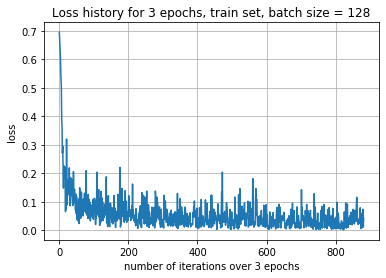

In [14]:
plot_loss(losses, N_EPOCHS, BATCH_SIZE)

In [19]:
def test(model, test_loader):
    # переключаем модель в режим eval
    model.eval()
    # не распространяем градиент по сети
    with torch.no_grad():
        # это для подсчета точности
        correct = 0
        total = 0
    
        for (inputs, targets) in test_loader:
            outputs = model(inputs)
            # берем максимальную вероятность по первой оси
            _, predicted = torch.max(outputs.data, 1)
            total +=  targets.size(0)
        
            correct += (predicted == targets).sum().item()
        # какая точность?    
        print(f"test accuracy: {100 * correct / total}")

In [20]:
test(net, test_loader)

test accuracy: 99.23339011925043
